# TensorFlow Data API

You may already found the numpy is nice and fast, but is not always the answer for the input data type.

Numpy is fast, but can be really memory demanding when using floats and lots of images.

One of the possible solutions is TensorFlow Data API that allows users to build a complex pipelines to process data.

TensorFlow Data API takes care of multithreading, queing, batching and prefetching for user.

Supports wide variety of different formats.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

https://www.tensorflow.org/guide/data


## TensorFlow Dataset

tf.data.Dataset is an abstraction representing possible large sequence of data.

You can either read data gradually from disk, or store dataset entirely in RAM.

Dataset is usually processed by chaining transformations to get the desired input. 

It is a Python iterable.


### Python iterators

Objects for iteration over collections.

With `yield` instead of `return`.

Yield do not terminate the function, it just pauses it and return control to a caller function.

It does not store collection in memory, just iterates item by item.

In [ ]:
def rev_str(my_str):
    length = len(my_str)
    for i in range(length - 1, -1, -1):
        yield my_str[i]
        print('+++')

for char in rev_str("hello"):
    print(char)

### Loading the data

For stroring whole dataset in RAM use **tf.data.Dataset.from_tensor_slices()**. This will return array of tensors in a Dataset object.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset
# dataset[3] will not work!

To display items you need to iterate over dataset and display all items.

In [ ]:
for elem in dataset:
    print(elem)

Or just a few items.

In [ ]:
for elem in dataset.take(4):
    print(elem)

Or just a single item by using Python iterator.

In [ ]:
it = iter(dataset)
print(next(it))

### Processing the data

Dataset are mainly for the chaining transformations.

You can batch the data for processing.

In [ ]:
batch_dataset = dataset.batch(3)

In [ ]:
for item in batch_dataset:
    print(item)

Or change the data.

In [ ]:
modified_data = dataset.map(lambda x: x * 2)

In [ ]:
for item in modified_data:
    print(item)

It is possible to run transformations on CPU in parallel.

In [ ]:
def multiply_by_three(item):
    return item * 3

In [ ]:
# tf.data.AUTOTUNE - number of parallel calls is set dynamically based on available 
# CPU https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
modified_data = dataset.map(multiply_by_three, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for item in modified_data:
    print(item)

## Working with the dataset

As I said, mostly you will work with the Dataset by chaining transformations that will be the best demonstrated in practical example.

In [ ]:
labels = pd.read_csv('labels.csv')
labels['path'] = 'mnist/'+labels['path']
display(labels)

In [ ]:
images = labels['path'].values
label = labels['label'].values

Load labels with image paths to the Dataset.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((images, label))

In [ ]:
for i in dataset.take(2):
    print(i)

### Apply transformations
Define function for processing the actual data.

In [ ]:
def process_images(filename, label):
    # read actual file from path to a Tensor
    image_string = tf.io.read_file(filename)
    # decode Tensor to jpg
    image = tf.image.decode_jpeg(image_string)
    # this method will convert uint8 to float and also normalize the data to [0..1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # reshape to 28x28, we don't need channels for Dense layer
    image = tf.reshape(image, (28,28))
    return image, label

Apply method to the Dataset.

In [ ]:
dataset = dataset.map(process_images)

### Shuffling data

*dataset.shuffle* enables shuffle of data that do not fit the RAM.

User needs to specify buffer size. Shuffle loads the data to the buffer and:
* when asked for item, it will pick random item from the buffer
* replace the item by a new one from source

In [ ]:
dataset = dataset.shuffle(1024)

### Batching the data

Takes only one minibatch of data for the training.

In [ ]:
dataset = dataset.batch(10)

### Prefetching the data

Sets number of batches that are prepared ahead for training. 

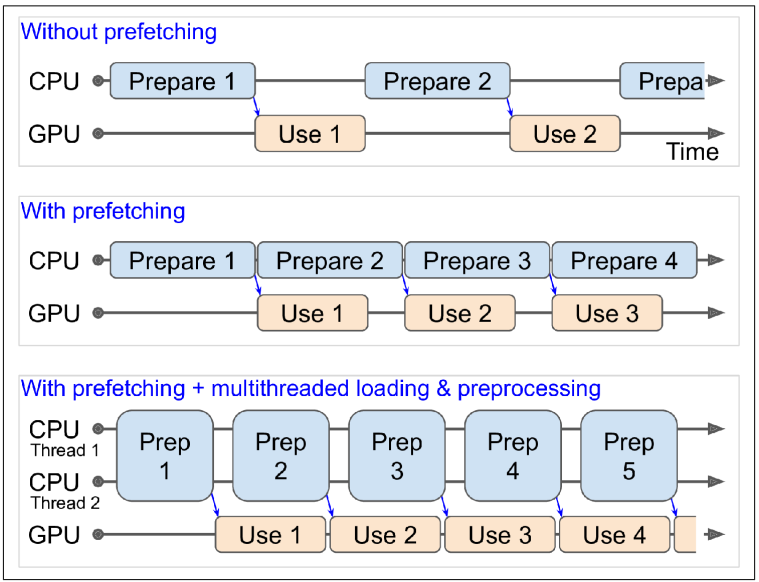

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
dataset

## Using TensorFlow.Datasets for training

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

Define model as we are used to.

In [ ]:
input_layer = Input(shape=(28, 28))
x = Flatten()(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)
model = Model(inputs = input_layer, outputs = output_layer)
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We don't need to specify batch, that's already set in the Dataset.

In [ ]:
history = model.fit(dataset,
                    epochs=10,
                    verbose=1)

## Generators

Are used in a case when you cannot fit the data to RAM.

Load the data to the Dataset that are really needed at the moment.

In [ ]:
from tensorflow.keras.datasets.fashion_mnist import load_data

In [ ]:
(train_image, train_label), (test_image, test_label) = load_data()

You need to provide a function that returns data from set until its exhausted.

In [ ]:
def image_generator(image, label, seed):
    # shuffle the array
    idx = np.arange(len(image))
    np.random.default_rng(seed).shuffle(idx)
    # return items one by one
    for i in idx:
        yield image[i]/255., label[i]

Create TensorFlow.Dataset from the generator.

In [ ]:
RANDOM_SEED = 42
# consiming image generator using function from_generator 
dataset = tf.data.Dataset.from_generator(
    # function that give us the data
    image_generator,
    # function parameters
    args=[train_image, train_label, RANDOM_SEED],
    # output of the function - we have 28x28 image and label, tf.Data constructs a graph, so it needs to know the shapes
    output_signature=(
        tf.TensorSpec(shape=(28,28), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.uint8)))

Display the data.

In [ ]:
for d in dataset.take(3):
    display(d)